# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

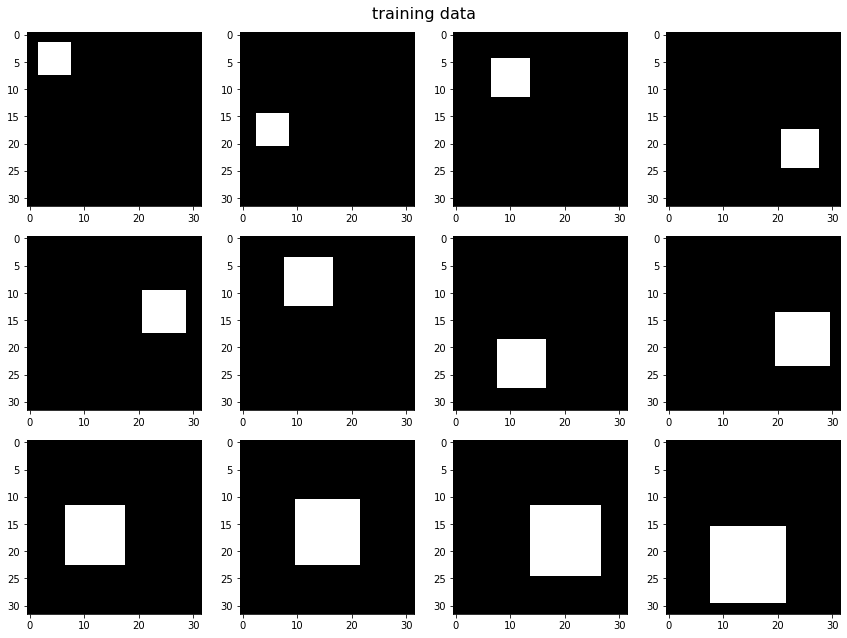

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

cuda


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(1024),
#             nn.LeakyReLU(0.2),
        )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=1024, out_features=256, bias=True),
#             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=128, out_features=64, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=64, out_features=32, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=32, out_features=16, bias=True),
# #             nn.LeakyReLU(0.2),
            
#             nn.Linear(in_features=256, out_features=1, bias=True),
#         )
        
#         self.network = nn.Sequential(
#             self.conv,
#             nn.Flatten(),
            
#             self.classifier,
#         )
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.flatten(out)
        
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.conv = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=dim_latent, out_channels=512, kernel_size=4, stride=1, padding=0, bias=True),
#             nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),
            
#             nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=2, stride=2, padding=0, bias=True),
#             nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        
#         self.batch_size = x.size(0)

#         x = self.fc(x),
# #         print(x, len(x))
#         x = torch.reshape(x[0], [self.batch_size, 1, 32, 32])
        out = self.conv(x)
        
#         out = self.network(x)
        return out

## build network

In [13]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [15]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [16]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [17]:
def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
        loss_image = nn.BCELoss()(fake, real)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
        loss_generator = loss_image / size_batch + loss_label
#         loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones_like(prediction_real, device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros_like(prediction_fake, device=device))
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)
        

## test

In [18]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [19]:
number_epoch    = 100
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in tqdm(range(number_epoch)):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch
    tqdm.write(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}, accuracy={accuracy}')

  1%|▊                                                                                  | 1/100 [00:07<12:25,  7.53s/it]

epoch 0, loss_generator = 0.8035662512536402, loss_discriminator=0.11460275087781527, accuracy=21.388214111328125


  2%|█▋                                                                                 | 2/100 [00:13<10:48,  6.62s/it]

epoch 1, loss_generator = 0.059253226496555185, loss_discriminator=0.0012061858743739626, accuracy=19.55596351623535


  3%|██▍                                                                                | 3/100 [00:19<10:09,  6.29s/it]

epoch 2, loss_generator = 0.03306129158095077, loss_discriminator=0.00038461760354780214, accuracy=18.307815551757812


  4%|███▎                                                                               | 4/100 [00:25<09:45,  6.10s/it]

epoch 3, loss_generator = 0.023422146533374433, loss_discriminator=0.00023184238358495618, accuracy=15.396651268005371


  5%|████▏                                                                              | 5/100 [00:31<09:28,  5.99s/it]

epoch 4, loss_generator = 0.02025274136276157, loss_discriminator=0.0002523593028416616, accuracy=11.28325080871582


  6%|████▉                                                                              | 6/100 [00:36<09:16,  5.92s/it]

epoch 5, loss_generator = 0.02059234213773851, loss_discriminator=0.00012766194565672239, accuracy=16.147315979003906


  7%|█████▊                                                                             | 7/100 [00:42<09:06,  5.88s/it]

epoch 6, loss_generator = 0.02367146750567136, loss_discriminator=8.875238897787682e-05, accuracy=14.877896308898926


  8%|██████▋                                                                            | 8/100 [00:48<08:58,  5.85s/it]

epoch 7, loss_generator = 0.024837602136863604, loss_discriminator=8.728541495791567e-05, accuracy=20.64917755126953


  9%|███████▍                                                                           | 9/100 [00:54<08:50,  5.83s/it]

epoch 8, loss_generator = 0.018968872898430737, loss_discriminator=8.040524257079663e-05, accuracy=14.883023262023926


 10%|████████▏                                                                         | 10/100 [00:59<08:44,  5.82s/it]

epoch 9, loss_generator = 0.01593517661784534, loss_discriminator=3.8147979615098816e-05, accuracy=11.479193687438965


 11%|█████████                                                                         | 11/100 [01:05<08:37,  5.81s/it]

epoch 10, loss_generator = 0.014311160147190093, loss_discriminator=2.7545272604146265e-05, accuracy=9.985516548156738


 12%|█████████▊                                                                        | 12/100 [01:11<08:31,  5.81s/it]

epoch 11, loss_generator = 0.014600008422577823, loss_discriminator=1.4855265073021183e-05, accuracy=10.151960372924805


 13%|██████████▋                                                                       | 13/100 [01:17<08:25,  5.81s/it]

epoch 12, loss_generator = 0.013259606325515995, loss_discriminator=1.8047576270840148e-05, accuracy=12.786642074584961


 14%|███████████▍                                                                      | 14/100 [01:23<08:20,  5.82s/it]

epoch 13, loss_generator = 0.017511138113008605, loss_discriminator=9.380117717228131e-06, accuracy=16.162639617919922


 15%|████████████▎                                                                     | 15/100 [01:29<08:14,  5.82s/it]

epoch 14, loss_generator = 0.015875065795801304, loss_discriminator=7.584362489338942e-06, accuracy=13.591830253601074


 16%|█████████████                                                                     | 16/100 [01:35<08:18,  5.93s/it]

epoch 15, loss_generator = 0.014774933636740402, loss_discriminator=6.474328146968792e-06, accuracy=12.263970375061035


 17%|█████████████▉                                                                    | 17/100 [01:41<08:15,  5.96s/it]

epoch 16, loss_generator = 0.0139855921820358, loss_discriminator=5.660647981063381e-06, accuracy=13.822942733764648


 18%|██████████████▊                                                                   | 18/100 [01:47<08:05,  5.93s/it]

epoch 17, loss_generator = 0.013228247956269317, loss_discriminator=5.128161144427765e-06, accuracy=11.211599349975586


 19%|███████████████▌                                                                  | 19/100 [01:52<07:57,  5.90s/it]

epoch 18, loss_generator = 0.0124675080732063, loss_discriminator=4.8656276619483295e-06, accuracy=9.011268615722656


 20%|████████████████▍                                                                 | 20/100 [01:58<07:50,  5.88s/it]

epoch 19, loss_generator = 0.014049647865747963, loss_discriminator=7.039863986493502e-06, accuracy=12.884142875671387


 21%|█████████████████▏                                                                | 21/100 [02:04<07:43,  5.86s/it]

epoch 20, loss_generator = 0.014938276192104374, loss_discriminator=4.0250688614294095e-06, accuracy=11.767242431640625


 22%|██████████████████                                                                | 22/100 [02:10<07:36,  5.85s/it]

epoch 21, loss_generator = 0.014489952509325964, loss_discriminator=3.5340235306783277e-06, accuracy=11.197818756103516


 23%|██████████████████▊                                                               | 23/100 [02:16<07:30,  5.85s/it]

epoch 22, loss_generator = 0.013943485536233143, loss_discriminator=3.276785971003712e-06, accuracy=10.582772254943848


 24%|███████████████████▋                                                              | 24/100 [02:22<07:23,  5.84s/it]

epoch 23, loss_generator = 0.012938299485378795, loss_discriminator=7.130607707916136e-06, accuracy=9.953886985778809


 25%|████████████████████▌                                                             | 25/100 [02:27<07:17,  5.84s/it]

epoch 24, loss_generator = 0.016143726336735265, loss_discriminator=6.76662324857952e-06, accuracy=11.172863006591797


 26%|█████████████████████▎                                                            | 26/100 [02:33<07:11,  5.84s/it]

epoch 25, loss_generator = 0.01495244912803173, loss_discriminator=3.610488717505952e-06, accuracy=9.51890754699707


 27%|██████████████████████▏                                                           | 27/100 [02:39<07:06,  5.84s/it]

epoch 26, loss_generator = 0.013933417235535603, loss_discriminator=3.052829274734163e-06, accuracy=4.712446212768555


 28%|██████████████████████▉                                                           | 28/100 [02:45<07:01,  5.85s/it]

epoch 27, loss_generator = 0.011795942871658891, loss_discriminator=5.92787267426805e-06, accuracy=10.420112609863281


 29%|███████████████████████▊                                                          | 29/100 [02:51<06:55,  5.85s/it]

epoch 28, loss_generator = 0.0108487362731938, loss_discriminator=1.3464650062276093e-05, accuracy=29.438621520996094


 30%|████████████████████████▌                                                         | 30/100 [02:57<06:50,  5.86s/it]

epoch 29, loss_generator = 0.01115614803576911, loss_discriminator=6.865720410200151e-06, accuracy=8.880022048950195


 31%|█████████████████████████▍                                                        | 31/100 [03:03<06:44,  5.87s/it]

epoch 30, loss_generator = 0.013865795669456322, loss_discriminator=3.645718850377846e-06, accuracy=11.135663032531738


 32%|██████████████████████████▏                                                       | 32/100 [03:09<06:44,  5.95s/it]

epoch 31, loss_generator = 0.011983743185798328, loss_discriminator=5.193246707440941e-06, accuracy=9.559603691101074


 33%|███████████████████████████                                                       | 33/100 [03:15<06:38,  5.95s/it]

epoch 32, loss_generator = 0.011591292151974308, loss_discriminator=6.688686113631303e-06, accuracy=14.310979843139648


 34%|███████████████████████████▉                                                      | 34/100 [03:21<06:30,  5.92s/it]

epoch 33, loss_generator = 0.012151482997945062, loss_discriminator=2.2538237043658296e-06, accuracy=11.942925453186035


 35%|████████████████████████████▋                                                     | 35/100 [03:26<06:23,  5.90s/it]

epoch 34, loss_generator = 0.014541383129027155, loss_discriminator=1.3593162066172227e-06, accuracy=8.797260284423828


 36%|█████████████████████████████▌                                                    | 36/100 [03:32<06:17,  5.89s/it]

epoch 35, loss_generator = 0.014213152629909692, loss_discriminator=1.187566822493493e-06, accuracy=9.164011001586914


 37%|██████████████████████████████▎                                                   | 37/100 [03:38<06:10,  5.89s/it]

epoch 36, loss_generator = 0.014109424163621884, loss_discriminator=1.040845706012516e-06, accuracy=6.679091453552246


 38%|███████████████████████████████▏                                                  | 38/100 [03:44<06:04,  5.88s/it]

epoch 37, loss_generator = 0.013870060637041375, loss_discriminator=8.974635349019351e-07, accuracy=7.356357574462891


 39%|███████████████████████████████▉                                                  | 39/100 [03:50<05:58,  5.87s/it]

epoch 38, loss_generator = 0.013780473179563327, loss_discriminator=8.088016919053323e-07, accuracy=7.112433910369873


 40%|████████████████████████████████▊                                                 | 40/100 [03:56<05:57,  5.96s/it]

epoch 39, loss_generator = 0.01370731986783169, loss_discriminator=7.512942543312588e-07, accuracy=6.828439235687256


 41%|█████████████████████████████████▌                                                | 41/100 [04:02<05:52,  5.97s/it]

epoch 40, loss_generator = 0.013661742569119843, loss_discriminator=6.654746610163581e-07, accuracy=6.230952739715576


 42%|██████████████████████████████████▍                                               | 42/100 [04:08<05:46,  5.97s/it]

epoch 41, loss_generator = 0.013566187479429774, loss_discriminator=6.156937470475693e-07, accuracy=9.182408332824707


 43%|███████████████████████████████████▎                                              | 43/100 [04:14<05:38,  5.94s/it]

epoch 42, loss_generator = 0.013542052924081132, loss_discriminator=5.784408689056296e-07, accuracy=7.15489387512207


 44%|████████████████████████████████████                                              | 44/100 [04:20<05:31,  5.92s/it]

epoch 43, loss_generator = 0.01343255038200705, loss_discriminator=5.424297438804826e-07, accuracy=6.9762282371521


 45%|████████████████████████████████████▉                                             | 45/100 [04:26<05:24,  5.90s/it]

epoch 44, loss_generator = 0.01332359849302857, loss_discriminator=5.11854767216425e-07, accuracy=5.592019557952881


 46%|█████████████████████████████████████▋                                            | 46/100 [04:32<05:18,  5.90s/it]

epoch 45, loss_generator = 0.013261318393051624, loss_discriminator=4.750158045344169e-07, accuracy=6.558262348175049


 47%|██████████████████████████████████████▌                                           | 47/100 [04:37<05:12,  5.89s/it]

epoch 46, loss_generator = 0.013162814791279811, loss_discriminator=4.568584763041549e-07, accuracy=7.495604515075684


 48%|███████████████████████████████████████▎                                          | 48/100 [04:43<05:09,  5.96s/it]

epoch 47, loss_generator = 0.01292917651158792, loss_discriminator=4.4863524900999133e-07, accuracy=12.069296836853027


 49%|████████████████████████████████████████▏                                         | 49/100 [04:50<05:05,  6.00s/it]

epoch 48, loss_generator = 0.012462816870322933, loss_discriminator=4.4427528215001747e-07, accuracy=11.781610488891602


 50%|█████████████████████████████████████████                                         | 50/100 [04:55<04:57,  5.96s/it]

epoch 49, loss_generator = 0.01145248337890263, loss_discriminator=7.674369351628195e-07, accuracy=39.713623046875


 51%|█████████████████████████████████████████▊                                        | 51/100 [05:01<04:50,  5.94s/it]

epoch 50, loss_generator = 0.010700660778416528, loss_discriminator=7.741426537045805e-07, accuracy=27.793720245361328


 52%|██████████████████████████████████████████▋                                       | 52/100 [05:07<04:44,  5.92s/it]

epoch 51, loss_generator = 0.010682311295359223, loss_discriminator=5.666854913552352e-07, accuracy=23.42813491821289


 53%|███████████████████████████████████████████▍                                      | 53/100 [05:13<04:37,  5.91s/it]

epoch 52, loss_generator = 0.01068733313155395, loss_discriminator=4.589280748674624e-07, accuracy=21.631650924682617


 54%|████████████████████████████████████████████▎                                     | 54/100 [05:19<04:31,  5.90s/it]

epoch 53, loss_generator = 0.010637796497731297, loss_discriminator=4.236896055923959e-07, accuracy=26.233774185180664


 55%|█████████████████████████████████████████████                                     | 55/100 [05:25<04:26,  5.92s/it]

epoch 54, loss_generator = 0.010667582194286365, loss_discriminator=3.6510597978020897e-07, accuracy=23.28146743774414


 56%|█████████████████████████████████████████████▉                                    | 56/100 [05:31<04:22,  5.96s/it]

epoch 55, loss_generator = 0.010624842925204171, loss_discriminator=3.4581725972034124e-07, accuracy=23.72011375427246


 57%|██████████████████████████████████████████████▋                                   | 57/100 [05:37<04:19,  6.04s/it]

epoch 56, loss_generator = 0.010666690677128457, loss_discriminator=3.1419369292962076e-07, accuracy=20.08283233642578


 58%|███████████████████████████████████████████████▌                                  | 58/100 [05:43<04:11,  5.99s/it]

epoch 57, loss_generator = 0.010657924110138857, loss_discriminator=2.993477245901751e-07, accuracy=16.60555648803711


 59%|████████████████████████████████████████████████▍                                 | 59/100 [05:49<04:04,  5.95s/it]

epoch 58, loss_generator = 0.010691715701034776, loss_discriminator=2.806936836181935e-07, accuracy=23.84568214416504


 60%|█████████████████████████████████████████████████▏                                | 60/100 [05:55<03:56,  5.92s/it]

epoch 59, loss_generator = 0.010672290367936646, loss_discriminator=2.7401575856081896e-07, accuracy=18.817529678344727


 61%|██████████████████████████████████████████████████                                | 61/100 [06:01<03:50,  5.91s/it]

epoch 60, loss_generator = 0.01066523003909323, loss_discriminator=2.601356046456944e-07, accuracy=18.468645095825195


 62%|██████████████████████████████████████████████████▊                               | 62/100 [06:07<03:44,  5.90s/it]

epoch 61, loss_generator = 0.010672669319642916, loss_discriminator=2.4625545357274087e-07, accuracy=24.962230682373047


 63%|███████████████████████████████████████████████████▋                              | 63/100 [06:12<03:37,  5.89s/it]

epoch 62, loss_generator = 0.010676451931121173, loss_discriminator=2.2092348143798046e-07, accuracy=15.364980697631836


 64%|████████████████████████████████████████████████████▍                             | 64/100 [06:18<03:31,  5.88s/it]

epoch 63, loss_generator = 0.010708163582064487, loss_discriminator=2.1965412305167707e-07, accuracy=24.226444244384766


 65%|█████████████████████████████████████████████████████▎                            | 65/100 [06:24<03:25,  5.88s/it]

epoch 64, loss_generator = 0.010741607458503158, loss_discriminator=1.9346671241169976e-07, accuracy=21.698863983154297


 66%|██████████████████████████████████████████████████████                            | 66/100 [06:30<03:19,  5.88s/it]

epoch 65, loss_generator = 0.08632289771404532, loss_discriminator=1.8709233221106505e-07, accuracy=46.798828125


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [06:36<03:13,  5.88s/it]

epoch 66, loss_generator = 0.10160848757735005, loss_discriminator=4.2976009998104324e-07, accuracy=36.091796875


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [06:42<03:07,  5.87s/it]

epoch 67, loss_generator = 0.06545129341107828, loss_discriminator=1.9724719461717339e-07, accuracy=29.509765625


 69%|████████████████████████████████████████████████████████▌                         | 69/100 [06:48<03:04,  5.95s/it]

epoch 68, loss_generator = 0.045719661398066415, loss_discriminator=2.2823607463561967e-07, accuracy=25.778663635253906


 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [06:54<02:59,  5.98s/it]

epoch 69, loss_generator = 0.031906578620826756, loss_discriminator=1.763855685247243e-07, accuracy=22.89582633972168


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [07:00<02:52,  5.95s/it]

epoch 70, loss_generator = 0.02320977108622039, loss_discriminator=1.4556225006909126e-07, accuracy=20.076644897460938


 72%|███████████████████████████████████████████████████████████                       | 72/100 [07:06<02:46,  5.94s/it]

epoch 71, loss_generator = 0.019720698120417417, loss_discriminator=1.2715656062575228e-07, accuracy=15.103730201721191


 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [07:12<02:39,  5.92s/it]

epoch 72, loss_generator = 0.018021283981700737, loss_discriminator=1.309094451934706e-07, accuracy=12.564550399780273


 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [07:17<02:33,  5.91s/it]

epoch 73, loss_generator = 0.01722923800073288, loss_discriminator=1.265218823799909e-07, accuracy=10.523174285888672


 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [07:23<02:27,  5.90s/it]

epoch 74, loss_generator = 0.016609844006597995, loss_discriminator=9.520185284057132e-08, accuracy=9.867416381835938


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [07:29<02:21,  5.89s/it]

epoch 75, loss_generator = 0.01625499654285334, loss_discriminator=7.676856683844933e-08, accuracy=9.148428916931152


 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [07:35<02:15,  5.88s/it]

epoch 76, loss_generator = 0.015953891289730866, loss_discriminator=5.687275977569091e-08, accuracy=7.629217147827148


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [07:41<02:09,  5.90s/it]

epoch 77, loss_generator = 0.015671748909409398, loss_discriminator=4.486904802600175e-08, accuracy=7.625308513641357


 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [07:47<02:03,  5.89s/it]

epoch 78, loss_generator = 0.0153431698679924, loss_discriminator=4.47310743112439e-08, accuracy=5.693469047546387


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [07:53<01:57,  5.89s/it]

epoch 79, loss_generator = 0.015072383710907565, loss_discriminator=3.9239721009946774e-08, accuracy=5.743633270263672


 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [07:59<01:51,  5.88s/it]

epoch 80, loss_generator = 0.01481039844867256, loss_discriminator=4.199919494983238e-08, accuracy=4.674368858337402


 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [08:05<01:45,  5.88s/it]

epoch 81, loss_generator = 0.014505504313166495, loss_discriminator=3.027143038458746e-08, accuracy=4.38974142074585


 83%|████████████████████████████████████████████████████████████████████              | 83/100 [08:10<01:39,  5.88s/it]

epoch 82, loss_generator = 0.014179934271507794, loss_discriminator=2.6187408630062446e-08, accuracy=4.304211139678955


 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [08:16<01:33,  5.87s/it]

epoch 83, loss_generator = 0.013914748067381206, loss_discriminator=2.315198741526998e-08, accuracy=3.9961438179016113


 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [08:22<01:29,  5.95s/it]

epoch 84, loss_generator = 0.013576475889594467, loss_discriminator=2.1523897632115385e-08, accuracy=3.8872904777526855


 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [08:29<01:24,  6.03s/it]

epoch 85, loss_generator = 0.012777211489500824, loss_discriminator=2.008897115159782e-08, accuracy=11.736455917358398


 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [08:35<01:18,  6.05s/it]

epoch 86, loss_generator = 0.011563520209380874, loss_discriminator=4.202678958751836e-08, accuracy=19.137903213500977


 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [08:41<01:11,  6.00s/it]

epoch 87, loss_generator = 0.01115770005379562, loss_discriminator=3.8963773434046113e-08, accuracy=21.470130920410156


 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [08:46<01:05,  5.96s/it]

epoch 88, loss_generator = 0.011035440965659088, loss_discriminator=3.3058498019703056e-08, accuracy=22.83951187133789


 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [08:52<00:59,  5.94s/it]

epoch 89, loss_generator = 0.010987379132873482, loss_discriminator=2.73463875774435e-08, accuracy=16.510360717773438


 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [08:58<00:53,  5.92s/it]

epoch 90, loss_generator = 0.010938716024436333, loss_discriminator=1.917834473288251e-08, accuracy=19.99665069580078


 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [09:04<00:47,  5.92s/it]

epoch 91, loss_generator = 0.01089389970595086, loss_discriminator=1.6943170767626093e-08, accuracy=18.869464874267578


 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [09:10<00:41,  5.90s/it]

epoch 92, loss_generator = 0.010865343838102288, loss_discriminator=1.658443912405866e-08, accuracy=19.42128562927246


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [09:16<00:35,  5.89s/it]

epoch 93, loss_generator = 0.01083998249636756, loss_discriminator=1.570140732658158e-08, accuracy=18.547348022460938


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [09:22<00:29,  5.89s/it]

epoch 94, loss_generator = 0.01079956830513698, loss_discriminator=1.2362443830766708e-08, accuracy=19.49517822265625


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [09:28<00:23,  5.88s/it]

epoch 95, loss_generator = 0.010821322738020509, loss_discriminator=1.007208042072652e-08, accuracy=18.903194427490234


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [09:33<00:17,  5.88s/it]

epoch 96, loss_generator = 0.010785366919029642, loss_discriminator=1.1341438390901873e-08, accuracy=29.975234985351562


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [09:39<00:11,  5.88s/it]

epoch 97, loss_generator = 0.010790843530385582, loss_discriminator=8.361206479442536e-09, accuracy=19.49243927001953


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [09:45<00:05,  5.88s/it]

epoch 98, loss_generator = 0.010791345037243985, loss_discriminator=7.285011560253662e-09, accuracy=17.330936431884766


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:51<00:00,  5.92s/it]

epoch 99, loss_generator = 0.010786839133059537, loss_discriminator=7.94728523977205e-09, accuracy=18.928184509277344


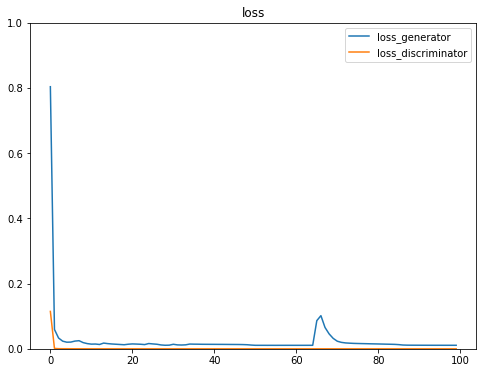

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(loss_generator, label='loss_generator')
plt.plot(loss_discriminator, label='loss_discriminator')
plt.ylim(0,1)
plt.legend()
plt.title('loss')
plt.show()

---

# functions for presenting the results

---

In [22]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [23]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [24]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



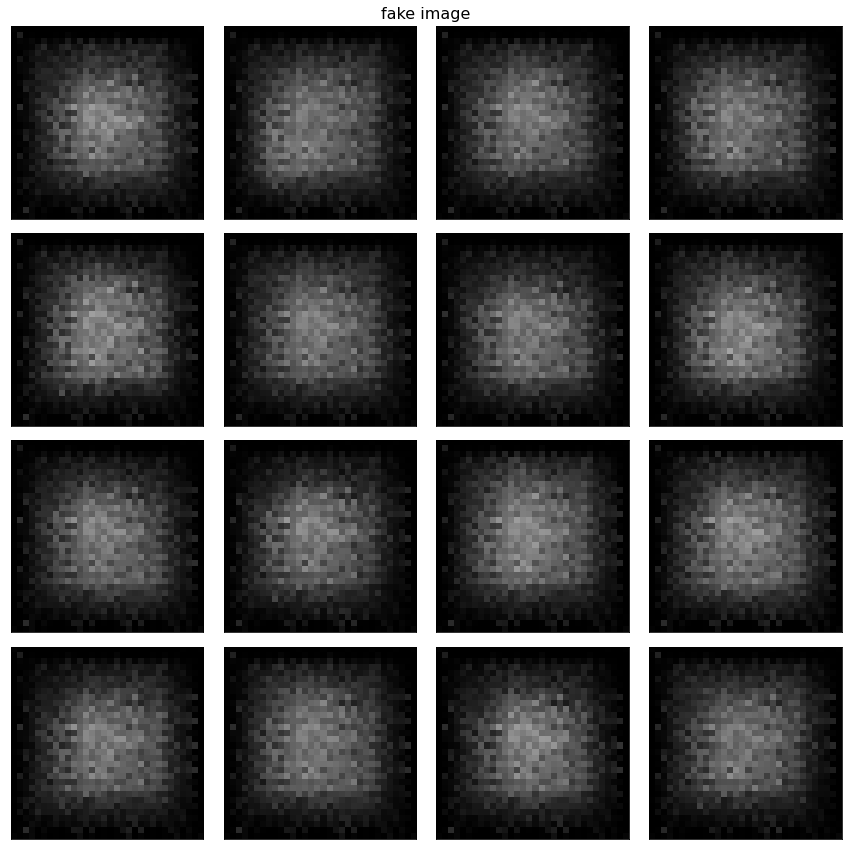

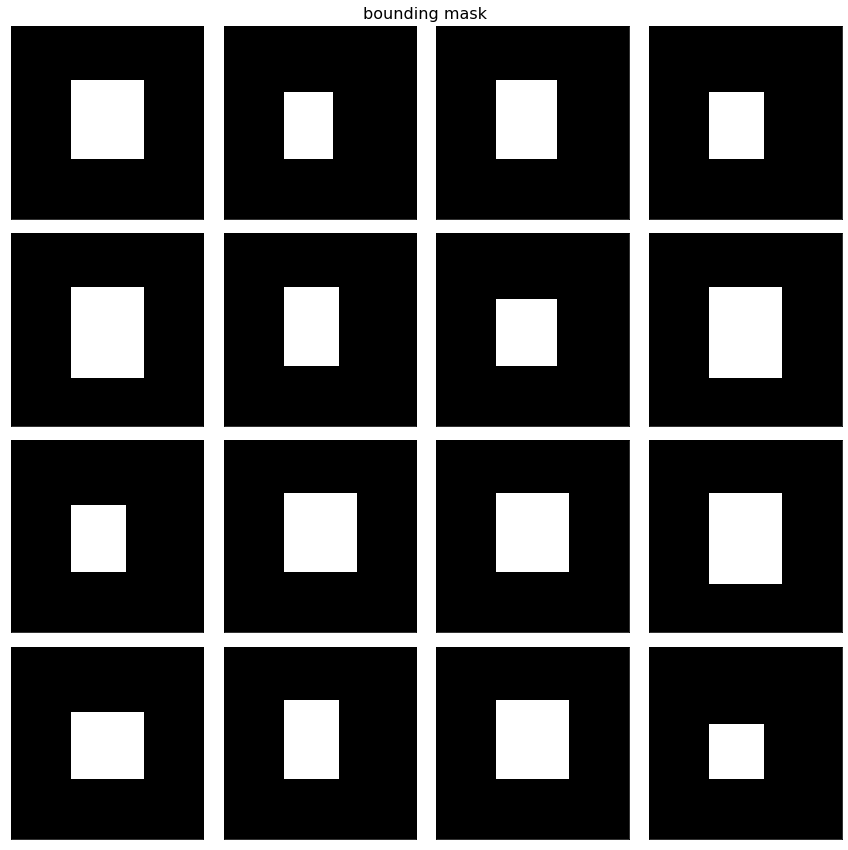


################################################################################
#
# RESULT # 02
#
################################################################################



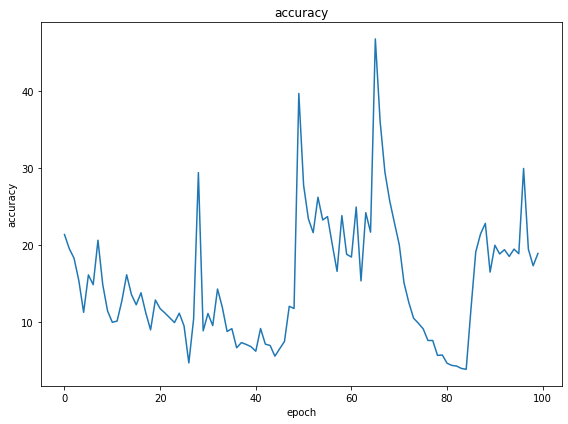


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 18.92818451


In [25]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [ ]:
# https://github.com/Lornatang/WassersteinGAN_GP-PyTorch/tree/master